# polynomial

In [181]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [182]:
df = pd.read_csv("..\OMLT_ML\data\polynomial3.csv")
df.head()

,theta,z,u
0,-20.0,-6.08,-3.92
1,-19.5,-5.58,-4.42
2,-19.1,-5.13,-4.87
3,-18.6,-4.71,-5.29
4,-18.1,-4.32,-5.68


In [183]:
X = df["theta"]
y = df["z"]
X = X.to_numpy().reshape(-1, 1)
y = y.to_numpy().reshape(-1, 1)
X.shape, y.shape

((180, 1), (180, 1))

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data_linear = lgb.Dataset(X_train, label=y_train, params = {'linear_tree': True,})
train_data_normal = lgb.Dataset(X_train, label=y_train, params = {'linear_tree': False,})

In [185]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 1,
    "verbosity": -1,
    'num_iterations': 4,
}

model_linear = lgb.train(params, train_data_linear)
model_normal = lgb.train(params, train_data_normal)

c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [186]:
y_pred_linear = model_linear.predict(X_test)
print(
    f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
y_pred_normal = model_normal.predict(X_test)
print(
    f"Normal trees error: {round(mean_squared_error(y_test, y_pred_normal),3)}")
y_linear = model_linear.predict(X)
y_normal = model_normal.predict(X)

Linear trees error: 0.862
Normal trees error: 1.471


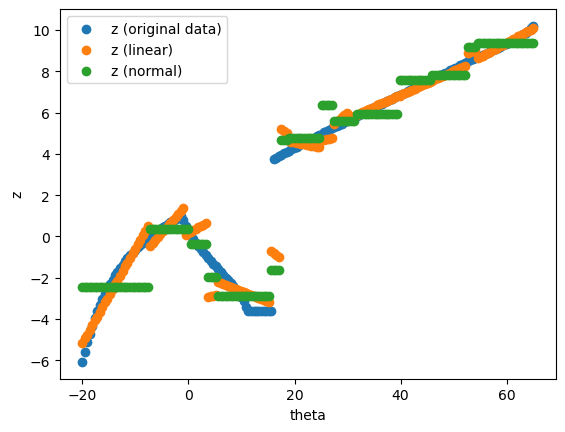

In [187]:
# plotting results
plt.scatter(X, y, label = 'z (original data)')
plt.scatter(X, y_linear, label = 'z (linear)')
plt.scatter(X, y_normal, label = 'z (normal)')
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()

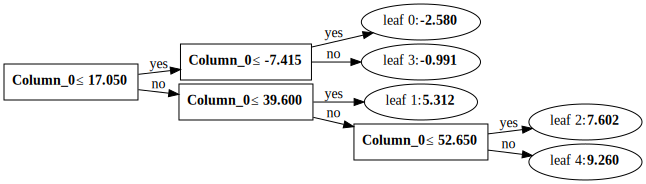

In [188]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'
# lgb.plot_tree(model_linear)
# for i in range(params['num_iterations']):
# p = lgb.create_tree_digraph(model_linear, params['num_iterations'] - 1)
p = lgb.create_tree_digraph(model_linear, 0)
p

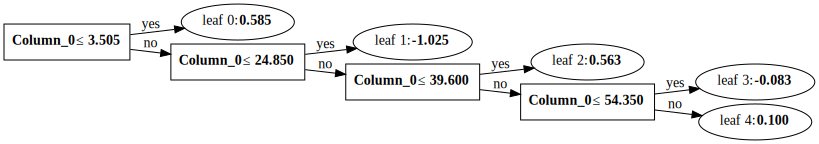

In [189]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'
# lgb.plot_tree(model_linear)
# for i in range(params['num_iterations']):
# p = lgb.create_tree_digraph(model_linear, params['num_iterations'] - 1)
p = lgb.create_tree_digraph(model_linear, 1)
p

In [190]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'
# # lgb.plot_tree(model_linear)
# # for i in range(params['num_iterations']):
# # p = lgb.create_tree_digraph(model_linear, params['num_iterations'] - 1)
# p = lgb.create_tree_digraph(model_linear, 2)
# p

In [191]:
from onnxmltools.convert.lightgbm.convert import convert
from skl2onnx.common.data_types import FloatTensorType

lgb_model = model_linear
float_tensor_type = FloatTensorType([None, lgb_model.num_feature()])
initial_types = [('float_input', float_tensor_type)]
onnx_model = convert(lgb_model,
                     initial_types=initial_types,
                     target_opset=8)

graph = onnx_model.graph

graph


node {
  input: "float_input"
  output: "variable"
  name: "LgbmRegressor"
  op_type: "TreeEnsembleRegressor"
  attribute {
    name: "n_targets"
    i: 1
    type: INT
  }
  attribute {
    name: "nodes_falsenodeids"
    ints: 2
    ints: 4
    ints: 6
    ints: 0
    ints: 0
    ints: 0
    ints: 8
    ints: 0
    ints: 0
    ints: 2
    ints: 0
    ints: 4
    ints: 0
    ints: 6
    ints: 0
    ints: 8
    ints: 0
    ints: 0
    ints: 2
    ints: 0
    ints: 4
    ints: 0
    ints: 6
    ints: 0
    ints: 8
    ints: 10
    ints: 0
    ints: 0
    ints: 0
    ints: 2
    ints: 0
    ints: 4
    ints: 0
    ints: 6
    ints: 0
    ints: 8
    ints: 10
    ints: 0
    ints: 0
    ints: 0
    type: INTS
  }
  attribute {
    name: "nodes_featureids"
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 

In [192]:
def _node_attributes(node):
    attr = dict()
    for at in node.attribute:
        attr[at.name] = at
    return attr

root_node = graph.node[0]
attr = _node_attributes(root_node)

# attr
base_value = (
    np.array(attr["base_values"].floats)[
        0] if "base_values" in attr else 0.0
)

# default left true
nodes_feature_ids = np.array(attr["nodes_featureids"].ints)
nodes_values = np.array(attr["nodes_values"].floats)
nodes_modes = np.array(attr["nodes_modes"].strings)
nodes_tree_ids = np.array(attr["nodes_treeids"].ints)
nodes_node_ids = np.array(attr["nodes_nodeids"].ints)
nodes_false_node_ids = np.array(attr["nodes_falsenodeids"].ints)
nodes_true_node_ids = np.array(attr["nodes_truenodeids"].ints)

n_targets = attr["n_targets"].i # assert is 1 or not
target_ids = np.array(attr["target_ids"].ints) # assert is same or not
target_node_ids = np.array(attr["target_nodeids"].ints)
target_tree_ids = np.array(attr["target_treeids"].ints)
target_weights = np.array(attr["target_weights"].floats)

nodes_leaf_mask = nodes_modes == b"LEAF"
nodes_branch_mask = nodes_modes == b"BRANCH_LEQ"

tree_ids = set(nodes_tree_ids)
feature_ids = set(nodes_feature_ids)

In [193]:
from collections import defaultdict
from collections import deque

splits_dic = defaultdict(dict)
leaves_dic = defaultdict(dict)
for i in tree_ids:
    # splits_dic[i] = {"node": nodes_node_ids[nodes_tree_ids==i]}
    node = nodes_node_ids[nodes_tree_ids == i]
    feature = nodes_feature_ids[nodes_tree_ids == i]
    value = nodes_values[nodes_tree_ids == i]
    mode = nodes_modes[nodes_tree_ids == i]
    target_weight = target_weights[target_tree_ids == i]
    count = 0
    count_leaf = 0
    queue = deque([node[count]])
    while queue:
        cur = queue[0]
        queue.popleft()
        # print(cur, mode[cur])
        if mode[cur] == b'BRANCH_LEQ':
            splits_dic[i][cur] = {'th': value[cur],
                                  'col': feature[cur],
                                  'children': [None, None]}
            queue.appendleft(node[count + 2])
            splits_dic[i][cur]['children'][0] = node[count + 1]
            queue.appendleft(node[count + 1])
            splits_dic[i][cur]['children'][1] = node[count + 2]
            count += 2
        else:
            # print(cur, i, count_leaf, target_weight[count_leaf])
            leaves_dic[i][cur] = {'val': target_weight[count_leaf]}
            count_leaf += 1

splits_dic, leaves_dic

(defaultdict(dict,
             {0: {0: {'th': 17.049999237060547, 'col': 0, 'children': [1, 2]},
               1: {'th': -7.414999961853027, 'col': 0, 'children': [3, 4]},
               2: {'th': 39.599998474121094, 'col': 0, 'children': [5, 6]},
               6: {'th': 52.650001525878906, 'col': 0, 'children': [7, 8]}},
              1: {0: {'th': 3.505000114440918, 'col': 0, 'children': [1, 2]},
               2: {'th': 24.850000381469727, 'col': 0, 'children': [3, 4]},
               4: {'th': 39.599998474121094, 'col': 0, 'children': [5, 6]},
               6: {'th': 54.349998474121094, 'col': 0, 'children': [7, 8]}},
              2: {0: {'th': -0.7705000042915344, 'col': 0, 'children': [1, 2]},
               2: {'th': 15.350000381469727, 'col': 0, 'children': [3, 4]},
               4: {'th': 27.25, 'col': 0, 'children': [5, 6]},
               6: {'th': 52.650001525878906, 'col': 0, 'children': [7, 8]},
               7: {'th': 39.599998474121094, 'col': 0, 'children': [9, 

# PHTSV

In [194]:
import numpy as np
from sklearn.linear_model import *
from lineartree import LinearTreeRegressor
import matplotlib.pyplot as plt
import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pp = pprint.PrettyPrinter(indent=4)
import time
import lightgbm as lgb
import pandas as pd


In [195]:
# Read the data from the csv file
data = np.genfromtxt('data/PHTSV_Table_HMAX_Adjusted.csv', delimiter=',')
data = data[1:, :]

# 2 D array containing Pressure and Enthalpy data
P_H = data[:, 0:2]

# Scale the pressure to bar and scale the enthalpy to kJ/mol
P_H[:, 0] = P_H[:, 0] / 1e5
P_H[:, 1] = P_H[:, 1] / 1000
minP = np.min(data[:, 0])
maxP = np.max(data[:, 0])
minH = np.min(data[:, 1])
maxH = np.max(data[:, 1])
print(minH)
print(maxH)
print(minP)
print(maxP)

# Vector containing Temperatures
T = data[:, 2]
minT = np.min(T)
maxT = np.max(T)


1.27588638
65.523
1.0
250.0


In [196]:
X_train, X_test, y_train, y_test = train_test_split(
    P_H, T, test_size=0.2, random_state=42)


In [197]:
lgb_dic = {}
train_data_linear = lgb.Dataset(
    X_train, label=y_train, params={'linear_tree': True, })
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.4,
    'num_leaves': 20,
    "verbosity": -1,
    'min_samples_leaf': 8,
    'max_bin': 60,
    'num_iterations': 10,
    'max_depth': 10,
}
time_start = time.time()
model_linear = lgb.train(params, train_data_linear)
time_end = time.time()
print('time cost:', time_end - time_start, 's')
y_pred_linear = model_linear.predict(X_test)
print(
    f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
df = model_linear.trees_to_dataframe()
# len(df[df["right_child"].isnull()]) == len(
#     df[df["left_child"].isnull()]) == len(df[df["decision_type"].isnull()])
print('numer of leaves:', len(df[df["right_child"].isnull()]))


time cost: 0.025933027267456055 s
Linear trees error: 22.614
numer of leaves: 200


c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [198]:
from onnxmltools.convert.lightgbm.convert import convert
from skl2onnx.common.data_types import FloatTensorType

lgb_model = model_linear
float_tensor_type = FloatTensorType([None, lgb_model.num_feature()])
initial_types = [('float_input', float_tensor_type)]
onnx_model = convert(lgb_model,
                     initial_types=initial_types,
                     target_opset=8)

graph = onnx_model.graph

# graph


In [199]:
def _node_attributes(node):
    attr = dict()
    for at in node.attribute:
        attr[at.name] = at
    return attr


root_node = graph.node[0]
attr = _node_attributes(root_node)

# attr
base_value = (
    np.array(attr["base_values"].floats)[
        0] if "base_values" in attr else 0.0
)

# default left true
nodes_feature_ids = np.array(attr["nodes_featureids"].ints)
nodes_values = np.array(attr["nodes_values"].floats)
nodes_modes = np.array(attr["nodes_modes"].strings)
nodes_tree_ids = np.array(attr["nodes_treeids"].ints)
nodes_node_ids = np.array(attr["nodes_nodeids"].ints)
nodes_false_node_ids = np.array(attr["nodes_falsenodeids"].ints)
nodes_true_node_ids = np.array(attr["nodes_truenodeids"].ints)

n_targets = attr["n_targets"].i  # assert is 1 or not
target_ids = np.array(attr["target_ids"].ints)  # assert is same or not
target_node_ids = np.array(attr["target_nodeids"].ints)
target_tree_ids = np.array(attr["target_treeids"].ints)
target_weights = np.array(attr["target_weights"].floats)

nodes_leaf_mask = nodes_modes == b"LEAF"
nodes_branch_mask = nodes_modes == b"BRANCH_LEQ"

tree_ids = set(nodes_tree_ids)
feature_ids = set(nodes_feature_ids)


In [200]:
# nodes_values[nodes_tree_ids == 9]

In [201]:
from collections import defaultdict
from collections import deque

splits_dic = defaultdict(dict)
leaves_dic = defaultdict(dict)
for i in tree_ids:
    # splits_dic[i] = {"node": nodes_node_ids[nodes_tree_ids==i]}
    node = nodes_node_ids[nodes_tree_ids==i]
    feature = nodes_feature_ids[nodes_tree_ids==i]
    value = nodes_values[nodes_tree_ids == i]
    mode = nodes_modes[nodes_tree_ids == i]
    target_weight = target_weights[target_tree_ids == i]
    count = 0
    count_leaf = 0
    queue = deque([node[count]])
    while queue:
        cur = queue[0]
        queue.popleft()
        # print(cur, mode[cur])
        if mode[cur] == b'BRANCH_LEQ':
            splits_dic[i][cur] = {'th': value[cur],
                                'col': feature[cur],
                                'children': [None, None]}
            queue.appendleft(node[count + 2])
            splits_dic[i][cur]['children'][0] = node[count+1]
            queue.appendleft(node[count + 1])
            splits_dic[i][cur]['children'][1] = node[count+2]
            count += 2
        else:
            # print(cur, i, count_leaf, target_weight[count_leaf])
            leaves_dic[i][cur] = {'val': target_weight[count_leaf]}
            count_leaf += 1

splits_dic[9], leaves_dic[9]

({0: {'th': 48.97450256347656, 'col': 1, 'children': [1, 2]},
  1: {'th': 12.632699012756348, 'col': 1, 'children': [3, 4]},
  3: {'th': 150.65151977539062, 'col': 0, 'children': [5, 6]},
  5: {'th': 10.036856651306152, 'col': 1, 'children': [7, 8]},
  7: {'th': 8.738934516906738, 'col': 1, 'children': [9, 10]},
  8: {'th': 9.803030014038086, 'col': 0, 'children': [11, 12]},
  4: {'th': 34.95454406738281, 'col': 0, 'children': [13, 14]},
  13: {'th': 15.22854232788086, 'col': 1, 'children': [15, 16]},
  16: {'th': 20.420228958129883, 'col': 1, 'children': [17, 18]},
  17: {'th': 24.893939971923828, 'col': 0, 'children': [19, 20]},
  14: {'th': 39.98484802246094, 'col': 0, 'children': [21, 22]},
  22: {'th': 45.01515197753906, 'col': 0, 'children': [23, 24]},
  23: {'th': 20.420228958129883, 'col': 1, 'children': [25, 26]},
  2: {'th': 61.95371627807617, 'col': 1, 'children': [27, 28]},
  27: {'th': 221.0757598876953, 'col': 0, 'children': [29, 30]},
  29: {'th': 60.65579605102539, 'col

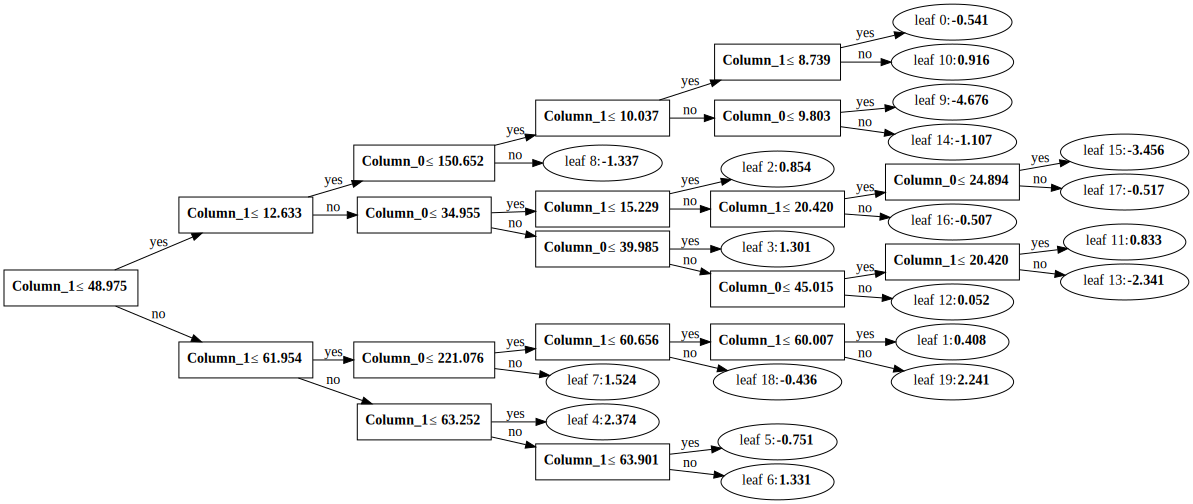

In [202]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'
# lgb.plot_tree(model_linear)
# for i in range(params['num_iterations']):
# p = lgb.create_tree_digraph(model_linear, params['num_iterations'] - 1)
p = lgb.create_tree_digraph(model_linear, -1)
p
